# CS 6923 FINAL PROJECT
## Michael Middleton

### What is the problem? Why is it important?
Decode a task using neuroimaging data from a EEG and a NIRS modality. Show the benefits in both with the hypothesis that no one modality is best for decoding. Then transcode a EEG signal in the prefrontal cortex from NIRS neuroimagery signal from a single subject. With the idea of upsampling the NIRS signal with learned information from the EEG signal.

Traditional non-invasive brain-computer interfaces (BCI) are either low resolution or low mobility. NIRS and EEG are highly portable devices with similar measurement systems. NIRS is less prone to movement artifacts then EEG and has better spatial resolution thus making it better for high mobility applications. However NIRS suffers in temporal resolution compared to EEG. Improving NIRS temporal resolution with learned EEG features that are transcoded from the NIRS signal is a step towards creating low-cost non-invasive BCI for real mobile applications.

NIRS measures changes in oxyginated and deoxyginated hemoglobin in the cortex of the brain. EEG measures electrical signals traveling through the brain and body. Both measurment systems use electrodes of similar size and placements.

### Previous Work:
Generalized neural decoders for transfer learning across participants and recording modalities - shows a transferable model between EEG and ECoG modalities that was only trained on ECoG. Limitations: These modalities are very similar, ECoG is basically a invasive version of EEG. The task is also a very simple task that shows that just spectral power features in a single band are enough to classify. This might not apply to other BCI devices or to other tasks.

Latent Neural Source Recovery via Transcoding of Simultaneous EEG-fMRI - Shows an end to end Cycle-CNN system for generating fMRI from EEG and using generated_fMRI + EEG for a output that has high spatial and high temporal resolution. Limitation: The measurement space between fMRI (image) and EEG(Voltage) is too different to accurately measure how well this is decoding fMRI from EEG. While NIRS measures similar hemoglobin patterns to fMRI, it is measured in a light intensity measurement from a electrode which output is similar to EEG Voltage.

### Dataset:
This project uses the Simultaneous acquisition of EEG and NIRS during cognitive tasks for an open access dataset 26 participants performing 3 tasks. Two of the tasks, n-back and discrimination/ selection response (DSR), have large clusters of samples in the 500 and 400 range. The last group, word generation, has only 40 samples. Since word generation has such a low number of samples, it was removed from the classification. N-back is a task where participants must remember a number that was shown to them in a group of numbers. Depending on the N size they are shown N number of numbers and then have to say if a number was N steps back or not. As N increases, the difficulty of the task also increases. In DSR, the subject is presented with a series of stimuli that represent a different response from the subject. The subject will respond in that different way depending on the stimuli. Both tasks had a 40 second tasking period and 20 second rest period and were recorded over multiple sessions.

### Structure of Report
This project first applies machine learning techniques to decoding DSR vs N-back. The project then looks at generating a EEG signal from only NIRS data using a spatial distribution of NIRS channels. This project proposes the comparison between a random forest ensamble for large feature sets and a gausian process classification/regressor for a sophisticated non-linear function learner. For the first task of decoding, the project looks at a basic classification pressision and f1 scoring metric. In the signal generation task, the project looks at r2 similarity and peak-signal-to-noise ratio to calculate simularity between the two signals.



## Imports ##

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import mne
from mne import events_from_annotations

from sklearn.model_selection import train_test_split

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process.kernels import RBF,WhiteKernel,Matern,RationalQuadratic,ExpSineSquared
from sklearn.metrics import classification_report, accuracy_score

from processing.Processing_EEG import process_eeg
from processing.Processing_NIRS import process_nirs

from utilities.Plotting import plot_eeg_nirs_brain,plot_covariance_matrix, plot_corelation_matrix
from utilities.Read_Data import read_subject_raw_nirs, read_subject_raw_eeg
from utilities.utilities import translate_channel_name_to_ch_id

## Constants ##

In [2]:
BASE_PATH = '/Users/mm/dev/super_resolution/eeg_fNIRs/shin_2017/data'

EEG_PATH = 'EEG_01-26_MATLAB/'
NIRS_PATH = 'NIRS_01-26_MATLAB/'

# eeg_time to fnirs_time
M_1=0.9998271160946597
C_1=-4.182145391771428
# fnirs_time to fnirs
M_2=10.416067241966067
C_2=0.2177377600651198

# EEG Channels names
EEG_CHANNEL_NAMES = ['Fp1', 
                    'AFF5h', 
                    'AFz', 
                    'F1', 
                    'FC5', 
                    'FC1', 
                    'T7', 
                    'C3', 
                    'Cz', 
                    'CP5', 
                    'CP1', 
                    'P7', 
                    'P3', 
                    'Pz', 
                    'POz', 
                    'O1',  
                    'Fp2', 
                    'AFF6h',
                    'F2', 
                    'FC2', 
                    'FC6', 
                    'C4', 
                    'T8', 
                    'CP2', 
                    'CP6', 
                    'P4', 
                    'P8', 
                    'O2', 
                    # 'TP9',
                    # 'TP10',
                    ]


# EEG Coordinates
EEG_COORDS = {'FP1':(-0.3090,0.9511,0.0001), #Fp1
                'AFF5':(-0.5417,0.7777,0.3163), #AFF5h
                'AFz':(0.0000,0.9230,0.3824),
                'F1':(-0.2888,0.6979,0.6542),
                'FC5':(-0.8709,0.3373,0.3549),
                'FC1':(-0.3581,0.3770,0.8532),
                'T7':(-1.0000,0.0000,0.0000),
                'C3':(-0.7066,0.0001,0.7066),
                'Cz':(0.0000,0.0002,1.0000),
                'CP5':(-0.8712,-0.3372,0.3552),
                'CP1':(-0.3580,-0.3767,0.8534),
                'P7':(-0.8090,-0.5878,-0.0001),
                'P3':(-0.5401,-0.6724,0.5045),
                'Pz':(0.0000,-0.7063,0.7065),
                'POz':(0.0000,-0.9230,0.3824),
                'O1':(-0.3090,-0.9511,0.0000),
                'FP2':(0.3091,0.9511,0.0000), #Fp2
                'AFF6':(0.5417,0.7777,0.3163), #AFF6h
                'F2':(0.2888,0.6979,0.6542),
                'FC2':(0.3581,0.3770,0.8532),
                'FC6':(0.8709,0.3373,0.3549),
                'C4':(0.7066,0.0001,0.7066),
                'T8':(1.0000,0.0000,0.0000),
                'CP2':(0.3580,-0.3767,0.8534),
                'CP6':(0.8712,-0.3372,0.3552),
                'P4':(0.5401,-0.6724,0.5045),
                'P8':(0.8090,-0.5878,-0.0001),
                'O2':(0.3090,-0.9511,0.0000),
                'TP9':(-0.8777,-0.2852,-0.3826),
                'TP10':(0.8777,-0.2853,-0.3826),
                
                'Fp1':(-0.3090,0.9511,0.0001),
                'AFF5h':(-0.5417,0.7777,0.3163),
                'Fp2':(0.3091,0.9511,0.0000),
                'AFF6h':(0.5417,0.7777,0.3163),}

# NIRS Ccoordinates
NIRS_COORDS = {
    'AF7':(-0.5878,0.809,0),
    'AFF5':(-0.6149,0.7564,0.2206),
    'AFp7':(-0.454,0.891,0),
    'AF5h':(-0.4284,0.875,0.2213),
    'AFp3':(-0.2508,0.9565,0.1438),
    'AFF3h':(-0.352,0.8111,0.4658),
    'AF1':(-0.1857,0.915,0.3558),
    'AFFz':(0,0.8312,0.5554),
    'AFpz':(0,0.9799,0.1949),
    'AF2':(0.1857,0.915,0.3558),
    'AFp4':(0.2508,0.9565,0.1437),
    'FCC3':(-0.6957,0.1838,0.6933),
    'C3h':(-0.555,0.0002,0.8306),
    'C5h':(-0.8311,0.0001,0.5552),
    'CCP3':(-0.6959,-0.1836,0.6936),
    'CPP3':(-0.6109,-0.5259,0.5904),
    'P3h':(-0.4217,-0.6869,0.5912),
    'P5h':(-0.6411,-0.6546,0.3985),
    'PPO3':(-0.4537,-0.796,0.3995),
    'AFF4h':(0.352,0.8111,0.4658),
    'AF6h':(0.4284,0.875,0.2212),
    'AFF6':(0.6149,0.7564,0.2206),
    'AFp8':(0.454,0.891,0),
    'AF8':(0.5878,0.809,0),
    'FCC4':(0.6957,0.1838,0.6933),
    'C6h':(0.8311,0.0001,0.5552),
    'C4h':(0.555,0.0002,0.8306),
    'CCP4':(0.6959,-0.1836,0.6936),
    'CPP4':(0.6109,-0.5258,0.5904),
    'P6h':(0.6411,-0.6546,0.3985),
    'P4h':(0.4216,-0.687,0.5912),
    'PPO4':(0.4537,-0.796,0.3995),
    'PPOz':(0,-0.8306,0.5551),
    'PO1':(-0.1858,-0.9151,0.3559),
    'PO2':(0.1859,-0.9151,0.3559),
    'POOz':(0,-0.9797,0.1949)}
    
# Fake source detector IDS
SOURCE_IDS = [1,1,1,1,2,2,2,3,3,3,4,4,4,5,5,5,6,6,6,6,7,7,7,7,8,8,8,8,9,9,9,9,10,10,10,10]
DETECTOR_IDS = list(np.arange(1,37))

## Parameters ##

In [3]:
## Subject/Trial Parameters ##
subject_ids = np.arange(1,2) # 1-27
subjects = []
for i in subject_ids:
    subjects.append(f'VP{i:03d}')

root_directory_eeg = '/Users/mm/dev/super_resolution/eeg_fNIRs/shin_2017/data/raw/eeg/VP001/'
root_directory_nirs = '/Users/mm/dev/super_resolution/eeg_fNIRs/shin_2017/data/raw/nirs/VP001/'

tasks = ['nback','gonogo','word']
task_stimulous_to_crop = {'nback': ['0-back session', '2-back session', '3-back session'],
                                'gonogo': ['gonogo session'],
                                'word': ['verbal_fluency', 'baseline']
                                }
trial_to_check_nirs = {'nback': ['2016-05-26_007', '2016-05-26_008', '2016-05-26_009',],
                       'gonogo': ['2016-05-26_001', '2016-05-26_002', '2016-05-26_003',],
                       'word': ['2016-05-26_004', '2016-05-26_005', '2016-05-26_006',],
                        }



## Epoch Parameters ##
t_min_eeg, t_max_eeg = -0.5, 0.9
t_min_nirs, t_max_nirs = -1, 10

#Translate event names
eeg_event_translations = {
                'nback': {
                    'Stimulus/S 16': '0-back target',
                    'Stimulus/S 48': '2-back target',
                    'Stimulus/S 64': '2-back non-target',
                    'Stimulus/S 80': '3-back target',
                    'Stimulus/S 96': '3-back non-target',
                    'Stimulus/S112': '0-back session',
                    'Stimulus/S128': '2-back session',
                    'Stimulus/S144': '3-back session'},
                'gonogo': {
                    'Stimulus/S 16': 'go',
                    'Stimulus/S 32': 'nogo',
                    'Stimulus/S 48': 'gonogo session'},
                'word': {
                    'Stimulus/S 16': 'verbal_fluency',
                    'Stimulus/S 32': 'baseline'}
}
nirs_event_translations = {
    'nback': {
        '7.0': '0-back session',
        '8.0': '2-back session',
        '9.0': '3-back session'},
    'gonogo': {
        '3.0': 'gonogo session'},
    'word': {
        '1.0': 'verbal_fluency',
        '2.0': 'baseline'}
}

eeg_task_names = {'nback':[
                '0-back target',
                '2-back target',
                '2-back non-target',
                '3-back target',
                '3-back non-target',
                ],
            'gonogo':[
                'go',
                'nogo',
                ],
            # 'word':[
            #     'verbal_fluency',
            #     'baseline',
            #     ]
            }


## SR Parameters ##
# EEG Downsampling rate
fnirs_sample_rate = 10
eeg_sample_rate = 60

# Time window
dt = 5
offsets = [-100, 0, 25, 50, 100]
offset = 50

# Train/Test Size
size = 1000
test_size = 100

nirs_channels_to_use = list(NIRS_COORDS.keys())
eeg_channels_to_use = EEG_CHANNEL_NAMES

## Model Definitions

We perform a randomcv parameter search of a set of kernel parameters for gausian process and tree depth and features for the random forest.

### Guasian Process
The Kernel for the guasian process was found to work best with a Matern Kernel * Exponential Sine Squared Kernel + White Noise Kernel. The matern Kernel is a base RBF kernel with a added smoothness metric, since the EEG signal is very jagged, this allows for specification that the kernel will need to find a rougher set of bounds. The Exponential Sine Squared Kernel adds a periodic element to the signal, which is assumed to be in both the EEG and NIRS signals due to repetitive tasking and physilogical noise. The white noise kernel was added to capture both environmental and physilogical noise that might be irrelevant of the task or signal generation.

A subset of data was run to optimize the parameters due to the large computation time of the guassian process. When optimizing the parameters of the kernels, very low values were found to be optimal. This is likely because the EEG and NIRS signal values are very small, e^-11 in some cases.

### Random Forest
Since Random forest is a lot faster of a model, we can afford to run a parameter search every time we fit the model no matter the size of the data. When running the parameter search we look for a optimal tree depth, split ratio, and tree parameters.

In [4]:
def get_gpc_model():
    # kernel = 1.0 * RBF(length_scale=0.0562, length_scale_bounds=(1e-05, 100000.0)) + WhiteKernel(
    #     noise_level=0.316, noise_level_bounds=(1e-25, 10.0)
    # )
    kernel = (1.0 * 
              Matern(length_scale=0.0562, length_scale_bounds=(1e-05, 5000.0), nu=0.5) * 
              ExpSineSquared(length_scale=10.0, periodicity=1.5, length_scale_bounds=(1e-05, 5000.0), periodicity_bounds=(1e-05, 5000.0)) + 
              WhiteKernel(noise_level=0.01, noise_level_bounds=(1e-05, 5000.0)
    )
    )
    gp = GaussianProcessClassifier(kernel=kernel, random_state=42)

    # print parameters
    print(gp.get_params())

    params_model = [{
        'model': [gp],
        # 'model__alpha': np.logspace(-2, 4, 5),
        'model__kernel__k1__k1__k1__constant_value_bounds': [(1e-05, 5000.0)],

        # 'model__kernel__k1__k1__k2__nu': [0.5, 1.5, 2.5, 3.5],
        # 'model__kernel__k1__k1__k2__length_scale': np.logspace(-2, 1, 5),
        # 'model__kernel__k1__k1__k2__length_scale_bounds': [(1e-10, 1e10), (1e-10, 1e15)],
        
        # 'model__kernel__k1__k2__periodicity': [0.5, 1.0, 1.5, 2.0],
        # 'model__kernel__k1__k2__length_scale': np.logspace(-2, 1, 5),
        # 'model__kernel__k1__k2__length_scale_bounds': [(1e-5, 1e5), (1e-10, 1e10)],
        # 'model__kernel__k1__k2__periodicity_bounds': [(1e-05, 150000.0), (1e-05, 200000.0)],

        # 'model__kernel__k2__noise_level': np.logspace(-2, 1, 5),
        # 'model__kernel__k2__noise_level_bounds': [(1e-300, 1e1)],

        # 'model__normalize_y': [True, False],
    }]
    return params_model

def get_random_forest_ensemble():
    
    params_model = [{
        'model': [RandomForestClassifier(random_state=42)],
        'model__n_estimators': [10, 100, 1000],
        'model__max_depth': [None, 5, 10, 20],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4],
        'model__max_features': [1.0, 'sqrt', 'log2'],
        'model__bootstrap': [True, False],
    }]
    return params_model

## Processing

After reading in the data for each subject, we have to perform a match in the stimulous indexes for each task. This is a limitation in the dataset itself as only session start indexes are labeled in the NIRS data while individual task types are labeled in the EEG data.

After we perform this match we perform signal preprocessing to each NIRS and EEG dataset individually.

### NIRS
NIRS is bandpass filtered between 0 and 5 hz. After we ensure all source channels are within 0.1 cm from the dector to ensure proper calibration of every channel we use. We then convert the raw voltage to optical density measurment. We then apply beer-lambert law to seperate oxyginated and deoxyginated hemoglobin measurments. We then filter out NIRS related noise.
NIRS, measuring hemoglobyn, has a number of physiological interferences that must be filterd out. Cardiac activities such as heartrate has a frequency range of 0.8 to 1.5 Hz, respiratory activities have a frequency range of 0.2-0.5 Hz, and arterial blood pressure changes have a frequency of 0.1 Hz (Mayer waves with very low-frequency volatility of about 0.04 Hz) [32]. Signals related to neural activities in fNIRS are generally at a frequency range of 0.003 to 0.08 Hz. Since there is a potential overlap in neural activity related signals and noise, a discrete wavlett decomposition function was performed to filter overlap. We choose the band between, 0.003 and 0.080.

![Alt text](nirs_processing-1.png)
The above image shows the different levels of the DWF and how the signal was reconstructed to remove noise below level 6.


Lastly we epoch the data based on a designated time of -1 to 10 seconds around each evoked stimulous. This large time window is to capture the delayed response of hemoglobyn changes.

### EEG
EEG is first band pass between 0 and 80 hz. This is because the voltage measurment below 1 hz for EEG is considered unreliable. We then use the EOG channels (which are channels at the base of the ear that just measure environmental noise and eye blinks) and a independent component analysis to filter out environmental noise and eye blinks. This is done manually by comparing the recordings of the EOG channel with the components in the ICA. We then reject any channels with a abnormaly high voltage measurment.

Lastly we epoch the data the same way as NIRS except we use as the EEG voltage response to stimulous is much faster then NIRS. We also seperate out specific band windows for alpha, beta, gamma, delta, and theta. This is to later make features based around these band windows as previous studies have shown that different neural activities accure in each band.

![Alt text](eeg_waves_processing-1.png)

The Above image shows the different bands of voltage data from EEG.

In [ ]:
# Get Voltage/Hemo from data
raw_eeg_voltage = []
raw_nirs_intensity = []
events_dict = {}
# Read and Combine task data
for task in tasks:
    raw_eeg_voltage_task, events_dict_task  = read_subject_raw_eeg(
        root_directory_eeg, 
        task,
        eeg_event_translations[task],
        task_stimulous_to_crop[task],
        eeg_coords=EEG_COORDS)
    
    _, single_events_dict = mne.events_from_annotations(raw_eeg_voltage_task)
    
    raw_nirs_intensity_task = read_subject_raw_nirs(
        root_directory_nirs, 
        {f'{v}': k for k, v in single_events_dict.items()},
        trial_to_check_nirs[task], 
        events_dict=events_dict_task, 
        correction_tuple=[M_1,C_1,M_2,C_2])

    raw_eeg_voltage.append(raw_eeg_voltage_task)
    raw_nirs_intensity.append(raw_nirs_intensity_task)

    last_subject_number = 0
    if len(events_dict) > 0:
        last_subject_number = np.max(list(events_dict.keys()))

    events_dict_tmp = {}
    for key, value in events_dict_task.items():
        events_dict_tmp[key + last_subject_number] = value

    events_dict.update(events_dict_tmp)
            
raw_eeg_voltage = mne.concatenate_raws(raw_eeg_voltage)
raw_nirs_intensity = mne.concatenate_raws(raw_nirs_intensity)

nirs_epochs, nirs_raw = process_nirs(
    raw_nirs_intensity, 
    t_min_nirs, 
    t_max_nirs, 
    events_dict=events_dict)
eeg_filtered_waves_raw, eeg_filtered_waves_epoch = process_eeg(
    raw_eeg_voltage, 
    t_min_eeg, 
    t_max_eeg, 
    # event_dict=event_dict_eeg, 
    resample=eeg_sample_rate)


print('eeg:')
print(eeg_filtered_waves_epoch)
print(eeg_filtered_waves_epoch['full'].events)
print('nirs:')
print(nirs_epochs)
print(nirs_epochs.events)

## Brain Channel Plot

(28, 84)
(72, 110)
(36, 110)
(36, 110)
['Fp1', 'AFF5h', 'AFz', 'F1', 'FC5', 'FC1', 'T7', 'C3', 'Cz', 'CP5', 'CP1', 'P7', 'P3', 'Pz', 'POz', 'O1', 'Fp2', 'AFF6h', 'F2', 'FC2', 'FC6', 'C4', 'T8', 'CP2', 'CP6', 'P4', 'P8', 'O2']
dict_keys(['AF7', 'AFF5', 'AFp7', 'AF5h', 'AFp3', 'AFF3h', 'AF1', 'AFFz', 'AFpz', 'AF2', 'AFp4', 'FCC3', 'C3h', 'C5h', 'CCP3', 'CPP3', 'P3h', 'P5h', 'PPO3', 'AFF4h', 'AF6h', 'AFF6', 'AFp8', 'AF8', 'FCC4', 'C6h', 'C4h', 'CCP4', 'CPP4', 'P6h', 'P4h', 'PPO4', 'PPOz', 'PO1', 'PO2', 'POOz'])


/Users/mm/dev/super_resolution/eeg_fNIRs/shin_2017/src/utilities/Plotting.py:211: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  all_info.set_montage(montage)


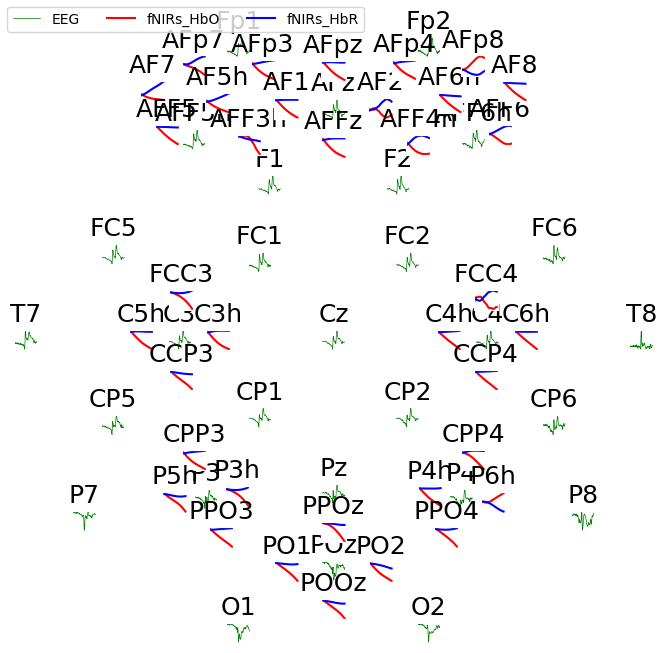

In [6]:
plot_eeg_nirs_brain(
    eeg_task_names['nback'], 
    eeg_filtered_waves_epoch['full'],
    nirs_epochs,
    eeg_coords=EEG_COORDS, 
    nirs_cords=NIRS_COORDS)
plt.show()

This figure shows the distribution of NIRS and EEG channels across the brain with the front of the brain being at the top of the image. Each channel shows there evoked response to the given stimulous averaged across trials. We can see a sharp difference in activity in EEG compared to a smooth transition in NIRS. This is due to both the NIRS being sampled at a much lower rate and the delayed hemodynamic response.

## Data Formatting ##

In [7]:
def get_psd_data(eeg_epoch, fmin=2.0, fmax=40.0):
    # Estimate PSDs based on "mean" and "median" averaging for comparison.
    psds_data, frequency_data = eeg_epoch.compute_psd(fmin=fmin, fmax=fmax).get_data(return_freqs=True)

    # Convert power to dB scale.
    psds_data = 10 * np.log10(psds_data)

    return psds_data, frequency_data

def get_xy_task_prediction(
        eeg_task_names, 
        eeg_channels_to_use, 
        eeg_epochs,
        nirs_channels_to_use,
        nirs_hemoglobin_epochs, 
        feature_sensors_to_use=[],
        eeg_translation_dict=None,
        nirs_translation_dict=None,
        dt=10,
        offset=0,):
    
    feature_sensors_to_use = [i.lower() for i in feature_sensors_to_use]
    
    # Dictionary for features
    feature_dict = {}

    # Get Data
    eeg_voltage_epochs = eeg_epochs['full'].pick(picks=eeg_channels_to_use)

    hbo_data = nirs_hemoglobin_epochs['hbo']
    hbr_data = nirs_hemoglobin_epochs['hbr']

    # Get Tasks
    eeg_task_list = []
    if type(eeg_task_names) == dict:
        for key, value in eeg_task_names.items():
            eeg_task_list = eeg_task_list + value
    else:
        eeg_task_list = eeg_task_names

    eeg_voltage_epochs = eeg_voltage_epochs[eeg_task_list]
    hbo_data = hbo_data[eeg_task_list].get_data()
    hbr_data = hbr_data[eeg_task_list].get_data()
    
    # Define band cutoffs
    band_cutoffs = {
        'delta': (0.5, 4.0),
        'theta': (4.0, 8.0),
        'alpha': (8.0, 12.0),
        'beta': (12.0, 30.0),
        'gamma': (30.0, 80.0),
    }

    # Process EEG features
    if len(feature_sensors_to_use) == 0 or 'eeg' in feature_sensors_to_use:
        for wave_type, (fmin, fmax) in band_cutoffs.items():

            # Ensure fmax does not exceed the Nyquist frequency
            if eeg_voltage_epochs.info['sfreq']/2 > fmax:
                print(f'Computing FFT for {wave_type}')

                eeg_psds_data, eeg_frequency_data = get_psd_data(eeg_voltage_epochs, fmin=fmin, fmax=fmax)
                eeg_psds_data = np.transpose(eeg_psds_data, axes=[1,2,0]) # (channels, time, trials)
                eeg_psds_data = np.average(eeg_psds_data, axis=1) # (channels, trials) Average time
                # eeg_psds_data =  eeg_psds_data.reshape(eeg_psds_data.shape[0]*eeg_psds_data.shape[1],eeg_psds_data.shape[2]).T

                feature_dict = feature_dict | {f'{eeg_channels_to_use[i]}_{wave_type}': eeg_psds_data[i,:] for i in range(eeg_psds_data.shape[0])}
            else:
                print(f'{wave_type} fmax {fmax} exceeds Nyquist frequency {eeg_voltage_epochs.info["sfreq"]/2}')

    # Process NIRS features
    if len(feature_sensors_to_use) == 0 or 'nirs' in feature_sensors_to_use:
        # Get n features
        feature_length = eeg_voltage_epochs.events.shape[0]
        
        hbo_feature = hbo_data[:feature_length, :].mean(axis=2)
        hbr_feature = hbr_data[:feature_length, :].mean(axis=2)
        print(hbo_feature.shape)
        # Add to feature dict
        feature_dict = feature_dict | {f'{nirs_channels_to_use[i]}_hbo': hbo_feature[:,i] for i in range(hbo_feature.shape[1])}
        feature_dict = feature_dict | {f'{nirs_channels_to_use[i]}_hbr': hbr_feature[:,i] for i in range(hbr_feature.shape[1])}
    
    # Process Labels
    labels = eeg_voltage_epochs.events[:, -1]
    if eeg_translation_dict is not None:
        # inverse dictionary 
        eeg_translation_dict_inverse = {v: k for k, v in eeg_translation_dict.items()}
        labels = np.array([eeg_translation_dict_inverse[l] for l in labels])

    if type(eeg_task_names) == dict:
        for task_name, sub_tasks in eeg_task_names.items():
            tmp = np.where(np.isin(labels, sub_tasks))[0]
            labels[tmp] = task_name


    # print counts
    uniue_labels, counts = np.unique(labels, return_counts=True)
    print(f'Unique labels: {list(zip(uniue_labels, counts))}')

    label_encoder = LabelEncoder().fit(labels)
    labels = label_encoder.transform(labels)

    features = pd.DataFrame(feature_dict)

    feature_labels = features.columns

    return features.to_numpy(), labels, feature_labels, label_encoder

## Pipeline ##

In [8]:
from sklearn.feature_selection import f_regression
from numpy.random import randint
from sklearn.base import BaseEstimator, TransformerMixin

class MRMRTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, k=5):
        self.k = k
        self.features = []

    def fit(self, x, y):
        """https://towardsdatascience.com/mrmr-explained-exactly-how-you-wished-someone-explained-to-you-9cf4ed27458b#:~:text=%E2%80%9CMaximum%20Relevance%20%2D%20Minimum%20Redundancy%E2%80%9D,been%20selected%20at%20previous%20iterations
        inputs:
            x: numpy array, features
            y: numpy array, target variable
            k: number of features to select
        outputs:
            compute F-statistics and initialize correlation matrix
        """
        x = pd.DataFrame(x) # want to do because of corrwith function
        y = pd.Series(y)

        # assert we are choosing n less than matrix features
        if self.k >= x.shape[1]:
          self.features = x.columns.to_list()
          return self

        f = pd.Series(f_regression(x, y)[0], index = x.columns)
        corr = pd.DataFrame(.00001, index = x.columns, columns = x.columns)

        # initialize list of selected features and list of excluded features
        selected = []
        not_selected = x.columns.to_list()

        # repeat K times
        for i in range(self.k):

            # compute (absolute) correlations between the last selected feature and all the (currently) excluded features
            if i > 0:
                last_selected = selected[-1]
                corr.loc[not_selected, last_selected] = x[not_selected].corrwith(x[last_selected]).abs().clip(.00001)

            # compute FCQ score for all the (currently) excluded features (this is Formula 2)
            score = f.loc[not_selected] / corr.loc[not_selected, selected].mean(axis = 1).fillna(.00001)

            # find best feature, add it to selected and remove it from not_selected
            best = score.index[score.argmax()]
            selected.append(best)
            not_selected.remove(best)

        self.features = selected

        return self

    def transform(self, x):
        return x[:,self.features]


In [22]:
def start_pipeline( 
                X_full,
                y_full,
                params_models,
                number_of_features = 'all',
                feature_labels=[],
                n_folds_outer=6,
                n_folds_inner=6,
                n_search = 20,
                label_encoder=None,
                feature_importance=False
):
  # params_models - create one dictionary per classification algorithm containing the hyperparameters to try within the randomized search
  # n_folds_outer - number of outer folds: percentage of samples reserved for test set will be 100/n_folds_inner
  # n_folds_inner - number of inner folds: percentage of samples reserved for test set will be 100/n_folds_inner
  # n_search - number of combinations of scaling/feature selection/balancing/models to evaluate to find best combination

  over = SMOTE(random_state=42, sampling_strategy='auto')
  under = RandomUnderSampler(random_state=42, sampling_strategy='auto')

  # make list of named pipeline steps in the order in which they should be applied to the feature matrix
  steps = [
    ('scaler', None),
    ('over', over), 
    # ('under', under),
    ('mutal_info', SelectKBest(mutual_info_classif, k=number_of_features)),
    ('model', None),
  ]

  # create a dictionary specifying different types of scaling, feature selection, and class balancing that you want to try within the randomized search
  if number_of_features is None:
    number_of_features = np.arange(20,100, 10)

  params_preprocessing = {
                          'scaler': [StandardScaler(), MinMaxScaler()],
                          }

  # for each classification algorithm, merge the dictionary for preprocessing with the dictionary for that model
  params = [params_preprocessing | x for x in params_models] # list comprehension

  cv_outer = StratifiedKFold(n_splits=n_folds_outer, shuffle=True, random_state=0)

  for train_i, test_i in cv_outer.split(X_full, y_full):
    X_train, X_test = X_full[train_i, :], X_full[test_i, :]
    y_train, y_test = y_full[train_i], y_full[test_i]

    # print counts
    uniue_labels, counts = np.unique(y_full, return_counts=True)
    print(f'Unique labels: {list(zip(uniue_labels, counts))}')

    print(f'train: {y_train.shape} test: {y_test.shape}')

    # obtain which indices will be the train data and validation data for inner folds
    cv_inner = StratifiedKFold(n_splits=n_folds_inner, shuffle=True, random_state=0)

    pipeline = Pipeline(steps)
    search = RandomizedSearchCV(pipeline,
                                params,
                                n_iter=n_search,
                                cv=cv_inner,
                                scoring='accuracy',
                                refit=True,
                                n_jobs=-1,
                                random_state=0)

    search.fit(X_train, y_train)
    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test)
    # y_pred_proba = model.predict_proba(X_test)
    
    if label_encoder is not None:
        y_test = label_encoder.inverse_transform(y_test)
        y_pred = label_encoder.inverse_transform(y_pred)

    print(classification_report(y_test, y_pred))
    print(search.best_params_)
    print(best_model)

    # best_features = best_model['MRMR'].features
    # if len(feature_labels) > 0:
    #     best_features = [feature_labels[i] for i in best_features]
    importances = []
    std= 0
    if feature_importance:
      importances = best_model['model'].feature_importances_
      std = np.std([tree.feature_importances_ for tree in best_model['model'].estimators_], axis=0)

    scores = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {scores}')

    best_features_fold = best_model['mutal_info'].get_support()
    best_features_fold = np.array(best_features_fold)

    best_features_translated = []
    for ind in range(best_features_fold.shape[0]):
        if np.any(best_features_fold[ind]):
            best_features_translated.append(feature_labels[ind])
            if feature_importance:
              print(feature_labels[ind])

    return best_model, importances, std, best_features_translated

In [10]:
# Predict EEG

# specific_tasks_eeg_epochs = eeg_voltage_epochs_mne[task_names].copy().pick(picks=eeg_channels_to_use)


tmp, eeg_translation_dict = mne.events_from_annotations(eeg_filtered_waves_raw['full'])

uniue_labels, counts = np.unique(tmp[:,2], return_counts=True)
print(f'Unique labels EEG: {list(zip(uniue_labels, counts))}')
print(eeg_translation_dict)

tmp, nirs_translation_dict = mne.events_from_annotations(nirs_raw)

uniue_labels, counts = np.unique(tmp[:,2], return_counts=True)
print(f'Unique labels NIRS: {list(zip(uniue_labels, counts))}')
print(nirs_translation_dict)

# Get NIRS Hemoglobin Data
nirs_channels_to_use_ids = translate_channel_name_to_ch_id(NIRS_COORDS, nirs_channels_to_use, nirs_epochs.ch_names)
print(nirs_channels_to_use_ids)

nirs_channels_to_use_hbo = [f'{c} hbo' for c in nirs_channels_to_use_ids]
nirs_channels_to_use_hbr = [f'{c} hbr' for c in nirs_channels_to_use_ids]

nirs_hemoglobin_epochs = {
    'hbo': nirs_epochs.copy().pick(picks=nirs_channels_to_use_hbo),
    'hbr': nirs_epochs.copy().pick(picks=nirs_channels_to_use_hbr),
}

Used Annotations descriptions: ['0-back session', '0-back target', '2-back non-target', '2-back session', '2-back target', '3-back non-target', '3-back session', '3-back target', 'Stimulus/S208', 'baseline', 'go', 'gonogo session', 'nogo', 'verbal_fluency']
Unique labels EEG: [(208, 3), (10001, 9), (10002, 180), (10003, 126), (10004, 9), (10005, 54), (10006, 126), (10007, 9), (10008, 54), (10009, 30), (10010, 108), (10011, 18), (10012, 252), (10013, 30)]
{'0-back session': 10001, '0-back target': 10002, '2-back non-target': 10003, '2-back session': 10004, '2-back target': 10005, '3-back non-target': 10006, '3-back session': 10007, '3-back target': 10008, 'Stimulus/S208': 208, 'baseline': 10009, 'go': 10010, 'gonogo session': 10011, 'nogo': 10012, 'verbal_fluency': 10013}
Used Annotations descriptions: ['0-back session', '0-back target', '2-back non-target', '2-back session', '2-back target', '3-back non-target', '3-back session', '3-back target', 'Stimulus/S208', 'baseline', 'go', 'gon

## Classification

### EEG Classification

In [23]:
X_full, y_full, feature_labels, label_encoder = get_xy_task_prediction(
    eeg_task_names, 
    eeg_channels_to_use, 
    eeg_filtered_waves_epoch,
    nirs_channels_to_use,
    nirs_hemoglobin_epochs,
    feature_sensors_to_use=['eeg'],
    eeg_translation_dict=eeg_translation_dict,
    nirs_translation_dict=nirs_translation_dict)

# print counts
uniue_labels, counts = np.unique(y_full, return_counts=True)
print(f'Unique labels: {list(zip(uniue_labels, counts))}')


print(f' X: {X_full.shape}')
print(f' y: {y_full.shape}')

print('GPC')
params_model = get_gpc_model()

best_model, _,_,_ = start_pipeline( 
            X_full,
            y_full,
            params_models=params_model,
            n_folds_outer=6,
            n_folds_inner=6,
            label_encoder=label_encoder,
            feature_labels=feature_labels,
            )

print('Random Forest')
params_model = get_random_forest_ensemble()

best_model, importances, std, best_features = start_pipeline( 
            X_full,
            y_full,
            params_models=params_model,
            n_folds_outer=6,
            n_folds_inner=6,
            label_encoder=label_encoder,
            feature_labels=feature_labels,
            feature_importance=True
            )

Computing FFT for delta
    Using multitaper spectrum estimation with 7 DPSS windows


Computing FFT for theta
    Using multitaper spectrum estimation with 7 DPSS windows
Computing FFT for alpha
    Using multitaper spectrum estimation with 7 DPSS windows
beta fmax 30.0 exceeds Nyquist frequency 30.0
gamma fmax 80.0 exceeds Nyquist frequency 30.0
Unique labels: [('gonogo', 341), ('nback', 513)]
Unique labels: [(0, 341), (1, 513)]
 X: (854, 84)
 y: (854,)
GPC
{'copy_X_train': True, 'kernel': None, 'max_iter_predict': 100, 'multi_class': 'one_vs_rest', 'n_jobs': None, 'n_restarts_optimizer': 0, 'optimizer': 'fmin_l_bfgs_b', 'random_state': 42, 'warm_start': False}
Unique labels: [(0, 341), (1, 513)]
train: (711,) test: (143,)


/Users/mm/anaconda3/envs/mne/lib/python3.11/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 2 is smaller than n_iter=20. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


              precision    recall  f1-score   support

      gonogo       0.69      0.79      0.74        57
       nback       0.85      0.77      0.80        86

    accuracy                           0.78       143
   macro avg       0.77      0.78      0.77       143
weighted avg       0.78      0.78      0.78       143

{'scaler': MinMaxScaler(), 'model': GaussianProcessClassifier(random_state=42)}
Pipeline(steps=[('scaler', MinMaxScaler()), ('over', SMOTE(random_state=42)),
                ('mutal_info',
                 SelectKBest(k='all',
                             score_func=<function mutual_info_classif at 0x1751a6020>)),
                ('model', GaussianProcessClassifier(random_state=42))])
Accuracy: 0.7762237762237763
Random Forest
Unique labels: [(0, 341), (1, 513)]
train: (711,) test: (143,)
              precision    recall  f1-score   support

      gonogo       0.74      0.61      0.67        57
       nback       0.77      0.86      0.81        86

    accuracy   

In [24]:
X_full, y_full, feature_labels, label_encoder = get_xy_task_prediction(
    eeg_task_names, 
    eeg_channels_to_use, 
    eeg_filtered_waves_epoch,
    nirs_channels_to_use,
    nirs_hemoglobin_epochs,
    feature_sensors_to_use=['nirs'],
    eeg_translation_dict=eeg_translation_dict,
    nirs_translation_dict=nirs_translation_dict)

# print counts
uniue_labels, counts = np.unique(y_full, return_counts=True)
print(f'Unique labels: {list(zip(uniue_labels, counts))}')


print(f' X: {X_full.shape}')
print(f' y: {y_full.shape}')

print('GPC')
params_model = get_gpc_model()

best_model, _,_,_ = start_pipeline( 
            X_full,
            y_full,
            params_models=params_model,
            n_folds_outer=6,
            n_folds_inner=6,
            label_encoder=label_encoder,
            feature_labels=feature_labels,
            )

print('Random Forest')
params_model = get_random_forest_ensemble()

best_model, importances, std, best_features = start_pipeline( 
            X_full,
            y_full,
            params_models=params_model,
            n_folds_outer=6,
            n_folds_inner=6,
            label_encoder=label_encoder,
            feature_labels=feature_labels,
            feature_importance=True
            )

(854, 36)
Unique labels: [('gonogo', 341), ('nback', 513)]
Unique labels: [(0, 341), (1, 513)]
 X: (854, 72)
 y: (854,)
GPC
{'copy_X_train': True, 'kernel': None, 'max_iter_predict': 100, 'multi_class': 'one_vs_rest', 'n_jobs': None, 'n_restarts_optimizer': 0, 'optimizer': 'fmin_l_bfgs_b', 'random_state': 42, 'warm_start': False}
Unique labels: [(0, 341), (1, 513)]
train: (711,) test: (143,)


/Users/mm/anaconda3/envs/mne/lib/python3.11/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 2 is smaller than n_iter=20. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


              precision    recall  f1-score   support

      gonogo       0.94      0.82      0.88        57
       nback       0.89      0.97      0.93        86

    accuracy                           0.91       143
   macro avg       0.92      0.89      0.90       143
weighted avg       0.91      0.91      0.91       143

{'scaler': StandardScaler(), 'model': GaussianProcessClassifier(random_state=42)}
Pipeline(steps=[('scaler', StandardScaler()), ('over', SMOTE(random_state=42)),
                ('mutal_info',
                 SelectKBest(k='all',
                             score_func=<function mutual_info_classif at 0x1751a6020>)),
                ('model', GaussianProcessClassifier(random_state=42))])
Accuracy: 0.9090909090909091
Random Forest
Unique labels: [(0, 341), (1, 513)]
train: (711,) test: (143,)
              precision    recall  f1-score   support

      gonogo       0.85      0.72      0.78        57
       nback       0.83      0.92      0.87        86

    accurac

### EEG and NIRS Classification

In [26]:
X_full, y_full, feature_labels, label_encoder = get_xy_task_prediction(
    eeg_task_names, 
    eeg_channels_to_use, 
    eeg_filtered_waves_epoch,
    nirs_channels_to_use,
    nirs_hemoglobin_epochs,
    feature_sensors_to_use=['eeg', 'nirs'],
    eeg_translation_dict=eeg_translation_dict,
    nirs_translation_dict=nirs_translation_dict)

# print counts
uniue_labels, counts = np.unique(y_full, return_counts=True)
print(f'Unique labels: {list(zip(uniue_labels, counts))}')


print(f' X: {X_full.shape}')
print(f' y: {y_full.shape}')

print('GPC')
params_model = get_gpc_model()

best_model, _,_,_ = start_pipeline( 
            X_full,
            y_full,
            params_models=params_model,
            n_folds_outer=6,
            n_folds_inner=6,
            label_encoder=label_encoder,
            feature_labels=feature_labels,
            number_of_features=100
            )

print('Random Forest')
params_model = get_random_forest_ensemble()

best_model, importances, std, best_features = start_pipeline( 
            X_full,
            y_full,
            params_models=params_model,
            n_folds_outer=6,
            n_folds_inner=6,
            label_encoder=label_encoder,
            feature_labels=feature_labels,
            feature_importance=True
            )

Computing FFT for delta
    Using multitaper spectrum estimation with 7 DPSS windows
Computing FFT for theta
    Using multitaper spectrum estimation with 7 DPSS windows
Computing FFT for alpha
    Using multitaper spectrum estimation with 7 DPSS windows
beta fmax 30.0 exceeds Nyquist frequency 30.0
gamma fmax 80.0 exceeds Nyquist frequency 30.0
(854, 36)
Unique labels: [('gonogo', 341), ('nback', 513)]
Unique labels: [(0, 341), (1, 513)]
 X: (854, 156)
 y: (854,)
GPC
{'copy_X_train': True, 'kernel': None, 'max_iter_predict': 100, 'multi_class': 'one_vs_rest', 'n_jobs': None, 'n_restarts_optimizer': 0, 'optimizer': 'fmin_l_bfgs_b', 'random_state': 42, 'warm_start': False}
Unique labels: [(0, 341), (1, 513)]
train: (711,) test: (143,)


/Users/mm/anaconda3/envs/mne/lib/python3.11/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 2 is smaller than n_iter=20. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


              precision    recall  f1-score   support

      gonogo       0.71      0.74      0.72        57
       nback       0.82      0.80      0.81        86

    accuracy                           0.78       143
   macro avg       0.77      0.77      0.77       143
weighted avg       0.78      0.78      0.78       143

{'scaler': MinMaxScaler(), 'model': GaussianProcessClassifier(random_state=42)}
Pipeline(steps=[('scaler', MinMaxScaler()), ('over', SMOTE(random_state=42)),
                ('mutal_info',
                 SelectKBest(k=100,
                             score_func=<function mutual_info_classif at 0x1751a6020>)),
                ('model', GaussianProcessClassifier(random_state=42))])
Accuracy: 0.7762237762237763
Random Forest
Unique labels: [(0, 341), (1, 513)]
train: (711,) test: (143,)
              precision    recall  f1-score   support

      gonogo       0.77      0.72      0.75        57
       nback       0.82      0.86      0.84        86

    accuracy     

For classification, random forest seems to work better. Random forest is a lot faster and easier to interpret than GPC. GPC is very finicky when it comes to tuning the kernel and the beefier model is not needed for this problem.

Interestingly we see that the model with only NIRS data (0.9) predicts a lot easier than a model with either EEG (0.77) only or both EEG and NIRS (0.8). I tried using multiple feature selecting algorithms to see if a subset of features can be found when training on EEG and NIRS and no feature selector seemed to find a good subset of features such that we see the same accuracy or bettr as the NIRS only dataset. The issue with the NIRS only dataset is that each feature is over a much larger time window of 10 seconds. This is to capture the delayed hemodynamic response. However, for a real time application, this delay can be detrimental to classification.

Thus waranting the need for a improved temporal resolution NIRS or a improved spatial resolution EEG. Both of which might be possible with signal prediction and super resolution.

### Feature Importance

Fp2_delta    0.048861
C5h_hbo      0.035208
T7_alpha     0.028166
AFpz_hbo     0.023944
AF1_hbo      0.017526
               ...   
AFz_alpha    0.002563
P8_theta     0.002459
FC5_alpha    0.002366
Cz_alpha     0.002112
F2_theta     0.002031
Length: 156, dtype: float64


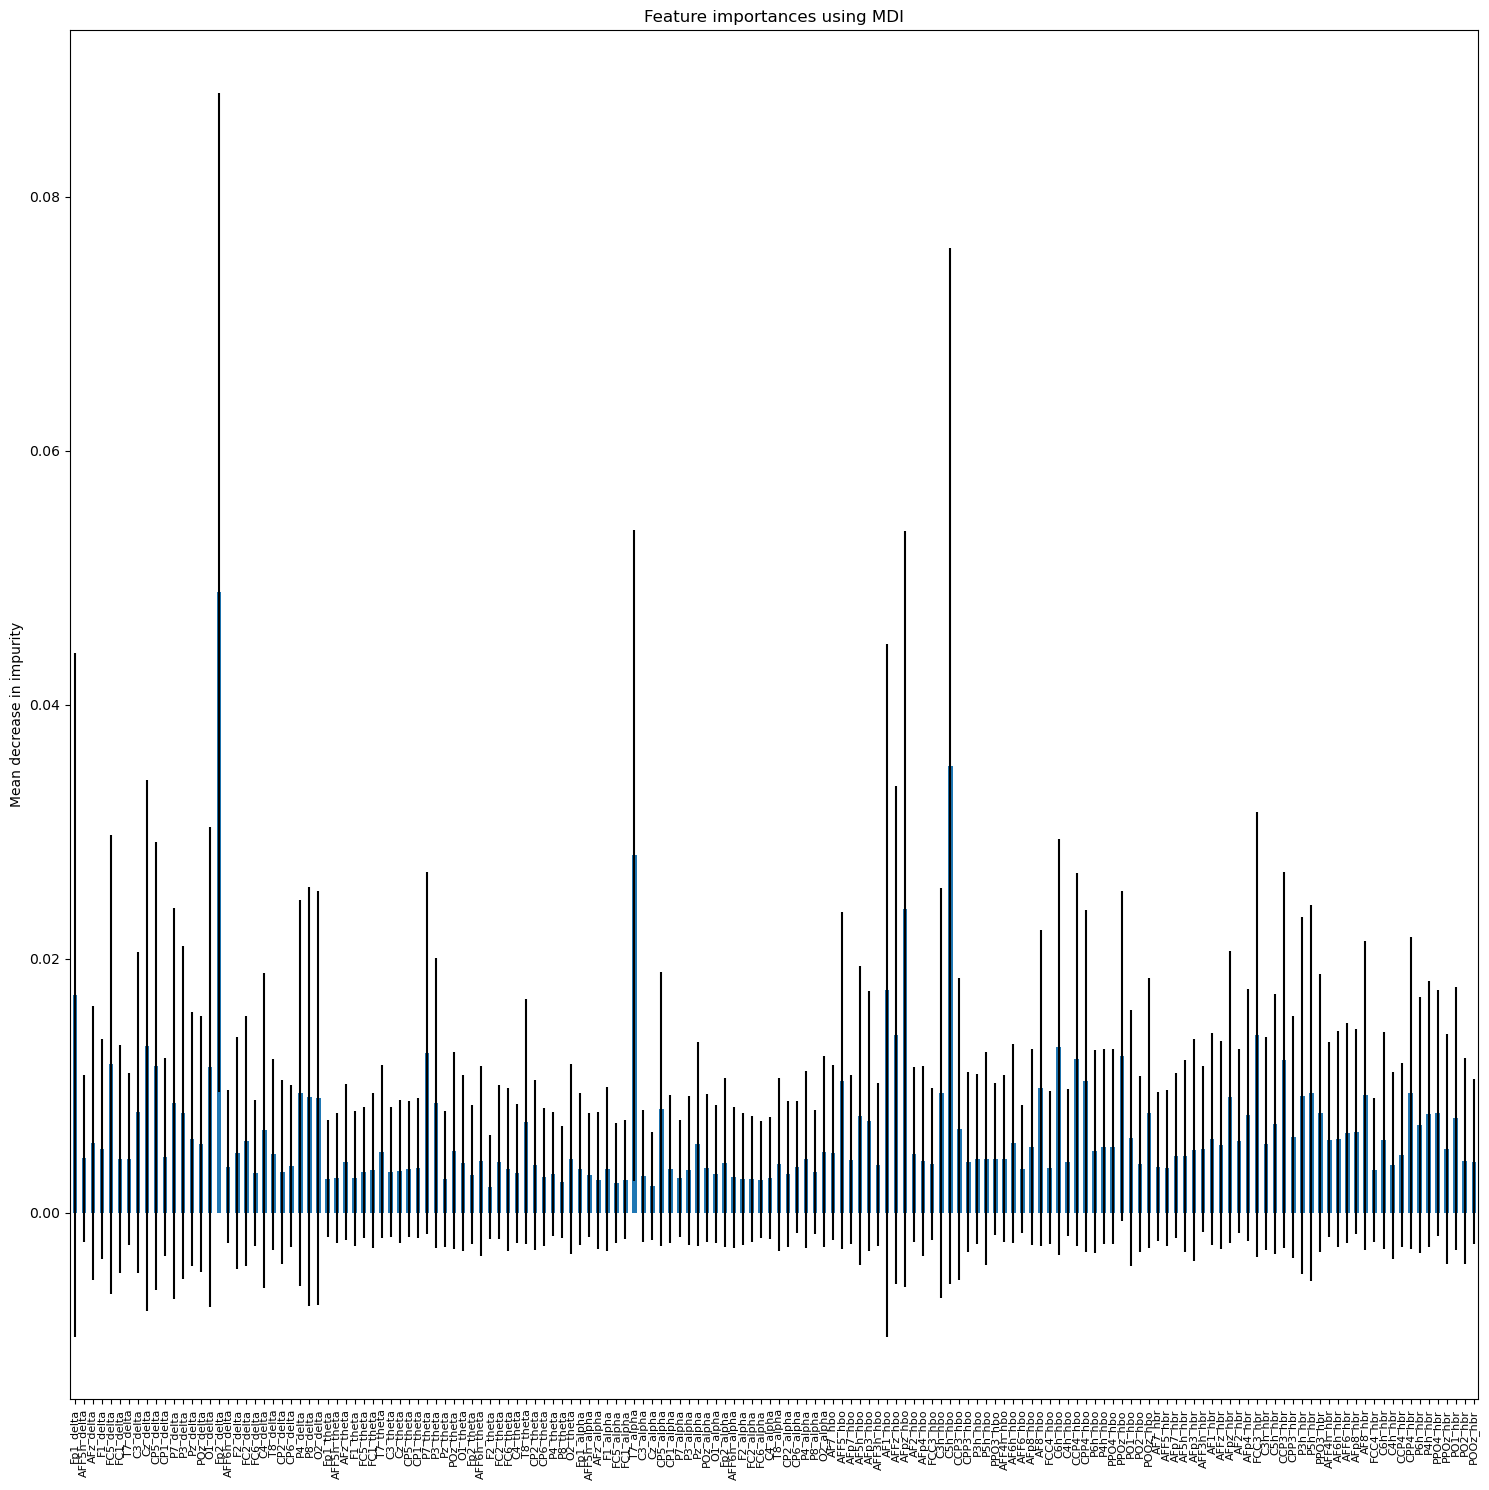

In [ ]:

forest_importances = pd.Series(importances, index=feature_labels)

fig, ax = plt.subplots(figsize=(15,15))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
plt.xticks(fontsize=8)
fig.tight_layout()

print(forest_importances.sort_values(ascending=False))

The features importance from random forest show high feature importance in a lot of prefrontal cortex channels. This is where a lot of the executive functions in your brain occur and where all parts of your brain communicate with. We also see some important features in the motor cortex. This is where movement decisions are made such as choosing to move your finger to press a button for a stimulous task. These results make sense although I would have expected more motor channels to be effective.

The features also show how important both NIRS and EEG channels are in the classification. Further proving the ability to enhance NIRS or EEG by predicting one signal from the other.

## Signal Prediction
The code for this section is inside the provided libraries. I ran out of time to implement into the Jupyter-notebook. The structure is the exact same as the pipeline structure in this notebook just with a different function to pull out x and y data.


We can define the signal prediction problem as such:

    Let:		
	    F_k,_i be the fnirs sample at 
                NIRS channel k and
                NIRS time i
        E_y,_i,_j be a eeg sample for 
                EEG channel y at 
                EEG sample j between two nirs samples. Where j: 0 -> eeg_fs/nirs_fs
                
    Then there exists some separate combination nirs channels and time windows such that:			
        [F_k=0,i=t,...,F_k=0,i=t+dt,F_k=1,i=t,...,F_k=1,i=t+dt,...,F_k=n,i=t,...,F_k=n,i=t+dt,] = Ey=0,i=t,j=0 
        [F_k=0,i=t,...,F_k=0,i=t+dt,F_k=1,i=t,...,F_k=1,i=t+dt,...,F_k=n,i=t,...,F_k=n,i=t+dt,] = Ey=0,i=t,j=1
        …
        [F_k=0,i=t,...,F_k=0,i=t+dt,F_k=1,i=t,...,F_k=1,i=t+dt,...,F_k=n,i=t,...,F_k=n,i=t+dt,] = Ey=0,i=t,j=x


        For
                dt = Time window size
                n = number of nirs channels
                x = eeg_fs/nirs_fs

So for every sample of EEG at time i. We train a seperate model for each time step j that is not in the NIRS signal due to sampling rate differences. Each model takes inputs of each NIRS channel k at samples over a time window dt. In the following models we look at a NIRS sampling rate of 10 hz predicting a EEG signal at 20hz. So there is two models trained to predict each EEG timestamp. We show results for guasian process regression and random forest ensamble.

## Results
### GPR
![Alt text](eeg_%5B'AFz'%5D_prediction_1_dt_5_offset_0_20231127-225943.png)


### Random Forest
![Alt text](eeg_%5B'AFF5'%5D_dt_5_offset_0_tree_20231120-095902.png) 


Although both models perform very poorly, guassian processes were able to get a r^2 of roughly 0.5 while random forest could only get to .2. This was my primary focus of this project and many preprocessing, hyperparameter tuning, and feature changes were made to get these model results. It seems in general GPR is possibly too powerfull to find a generalized solution to this problem, after highly tuning the kernel for GPR the training accuracy is great but testing always falls short. Random Forest does not seem powerfull enough for this problem. Although there are quite a few features, it seems working and predicting with small highly volatile data points is too much for forests.

![Alt text](FP1_full_Covariance.png)

These covariance plots showcase how spatially and temporally distributed the NIRS and EEG data are. The y axis of each matrix is of shape k*dt and x of j eeg time stamps. The location of the matrix is the spatial distribution over the brain. We can see some correlations in the center indicating that there is no delay in the prediction. Offset correlations indicate a time difference between the prediction and the nirs signal. Each of these correlation matrixes have individual color windows that are independt of each other. I hope to use these covariance and correlation plots to correlate time windows and channels to there respective EEG channels.

## Future work:
In future work a deep neural network achitecture such as a cnn that can find the optimal time window and spatial distribution of features for a given EEG channel prediction is likely to provide the best results. A transformer model that can have some sort of memory of features over time will also likely be ben eficial. The next model I will test is a super-resolution version of EEGNet. EEGNet is a decoder made specifically for EEG data. I will add a convolution that learns a low temporal resolution feature map (NIRS) and another added convolution that learns a high temporal resolution feature map (EEG). These two convolutions will have a non-linear mapping between them that tries to learn how to upsample the NIRS signal into the EEG signal.